In [4]:
import os 
import pytorch_lightning as pl
import seml
import numpy as np
import torch

from sacred import SETTINGS, Experiment
from functools import partial

import scanpy as sc
import scvelo as scv
import cellrank as cr
import pandas as pd

from scCFM.datamodules.sc_datamodule import scDataModule
from scCFM.datamodules.time_sc_datamodule import TrajectoryDataModule
from scCFM.models.base.vae import VAE, AE
from scCFM.models.cfm.cfm_module import CFMLitModule
from scCFM.models.cfm.components.simple_mlp import VelocityNet

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger

from torch.optim import AdamW

import yaml

import sys 
sys.path.insert(0, "../../../" )
from paths import EXPERIMENT_FOLDER

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


## Import configurations

In [5]:
with open("/nfs/homedirs/pala/scCFM/configs/ae/eb/config.yaml", "r") as stream:
    hparams_ae = yaml.safe_load(stream)["fixed"]
with open("/nfs/homedirs/pala/scCFM/configs/trajectory/eb/config.yaml", "r") as stream:
    hparams_cfm = yaml.safe_load(stream)["fixed"]

## Initialize and train/load autoencoder 

In [6]:
pretrained_ae = True
pretrained_ckpt_ae = "/nfs/students/pala/scCFM/experiments/ae/eb_vae/checkpoints/epoch_0033.ckpt"

In [7]:
task_name = hparams_ae["training.training"]["task_name"]
        
# Fix seed for reproducibility
torch.manual_seed(hparams_ae["training.training"]["seed"])      
if hparams_ae["training.training"]["seed"]: 
    pl.seed_everything(hparams_ae["training.training"]["seed"], workers=True)

# Initialize folder 
current_experiment_dir = EXPERIMENT_FOLDER / "ae" / task_name
current_experiment_dir.mkdir(parents=True, exist_ok=True) 
    

# Initialize datamodule
datamodule = scDataModule(**hparams_ae["datamodule.datamodule"])


# Initialize the model 
ae_model = VAE(in_dim = datamodule.dim,
            **hparams_ae["model.model"]
            ) 
        
if not pretrained_ae:
    # Initialize callbacks 
    model_ckpt_callbacks = ModelCheckpoint(dirpath=current_experiment_dir / "checkpoints", 
                                            **hparams_ae["model_checkpoint.model_checkpoint"])


    # Initialize callbacks 
    early_stopping_callbacks = EarlyStopping(**hparams_ae["early_stopping.early_stopping"])


    # Initialize logger 
    logger = WandbLogger(save_dir=current_experiment_dir / "logs", 
                         **hparams_ae["logger.logger"]) 


    # Initialize the lightning trainer 
    trainer = Trainer(default_root_dir=current_experiment_dir,
                      callbacks=[model_ckpt_callbacks, early_stopping_callbacks], 
                      logger=logger, 
                      **hparams_ae["trainer.trainer"])


    # # Fit the model 
    trainer.fit(model=ae_model, 
                      train_dataloaders=datamodule.train_dataloader(),
                      val_dataloaders=datamodule.val_dataloader())
    train_metrics = trainer.callback_metrics

else:
    ae_model.load_state_dict(torch.load(pretrained_ckpt_ae)["state_dict"])

[rank: 0] Global seed set to 42
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


**Analyze autoencoder latent space**

In [8]:
z_cells = []
annot = []
with torch.no_grad():
    for batch in datamodule.train_dataloader():
        annot.append(batch["cond"])
        mu = ae_model.encode(batch["X"])["z"]
        z_cells.append(mu)

z_cells= torch.cat(z_cells, dim=0)
annot = pd.DataFrame(torch.cat(annot).numpy())
annot.columns = ["experimental_time"]

adata_latent = sc.AnnData(X=z_cells.cpu().numpy(), 
                  obs=annot)

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
sc.tl.pca(adata_latent)
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)

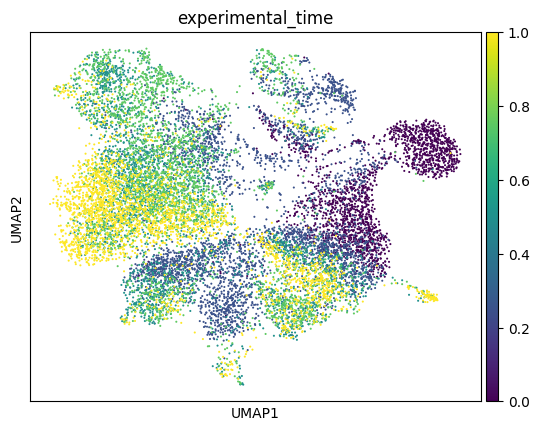

In [10]:
sc.pl.umap(adata_latent, color="experimental_time")

## Initialize and train CFM in latent space

In [11]:
pretrained_cfm = False
pretrained_ckpt_cfm = "/nfs/students/pala/scCFM/experiments/eb/checkpoints/epoch_0087-v1.ckpt"

In [12]:
task_name = hparams_cfm["training.training"]["task_name"]
        
# Fix seed for reproducibility
torch.manual_seed(hparams_cfm["training.training"]["seed"])      
if hparams_cfm["training.training"]["seed"]: 
    pl.seed_everything(hparams_cfm["training.training"]["seed"], workers=True)

# Initialize folder 
current_experiment_dir = EXPERIMENT_FOLDER / task_name
current_experiment_dir.mkdir(parents=True, exist_ok=True) 
    

# Initialize datamodule
datamodule = TrajectoryDataModule(**hparams_cfm["datamodule.datamodule"])
    

# Neural network 
net = partial(VelocityNet, **hparams_cfm["net.net"])   


# Initialize the model 
model = CFMLitModule(
                    autoencoder=ae_model,
                    net=net,
                    datamodule=datamodule,
                    **hparams_cfm["model.model"]
                    ) 
        

# Initialize callbacks 
model_ckpt_callbacks = ModelCheckpoint(dirpath=current_experiment_dir / "checkpoints", 
                                        **hparams_cfm["model_checkpoint.model_checkpoint"])


# Initialize callbacks 
early_stopping_callbacks = EarlyStopping(**hparams_cfm["early_stopping.early_stopping"])
        

# Initialize logger 
logger = WandbLogger(save_dir=current_experiment_dir / "logs", 
                     **hparams_cfm["logger.logger"]) 
        

# Initialize the lightning trainer 
trainer = Trainer(default_root_dir=current_experiment_dir,
                  callbacks=[model_ckpt_callbacks, early_stopping_callbacks], 
                  logger=logger, 
                  **hparams_cfm["trainer.trainer"])
        
if not pretrained_cfm:
    # Fit the model 
    trainer.fit(model=model, 
                      train_dataloaders=datamodule.train_dataloader(load_full=True),
                      val_dataloaders=datamodule.val_dataloader(load_full=False))
    train_metrics = trainer.callback_metrics
else:
    model.load_state_dict(torch.load(pretrained_ckpt_cfm)["state_dict"])

[rank: 0] Global seed set to 42
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'autoencoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['autoencoder'])`.
  rank_zero_warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id vqu9wuik.


/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-pa ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-pa ...
  rank_zero_warn(
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/pytorch_lightning

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


**Analysis velocity**

In [13]:
adata = sc.read_h5ad("/nfs/homedirs/pala/scCFM/project_dir/data/eb/eb_phate.h5ad")
adata

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 16821 × 1579
    obs: 'experimental_time'
    var: 'ensid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'day_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_log', 'X_norm'
    obsp: 'connectivities', 'distances'

In [14]:
def add_velocity_to_adata(adata, model):
    # Put model in evaluation mode
    model.eval()
    velocities = []
    with torch.no_grad():
        for i, x in enumerate(adata.X):
            t = torch.tensor(adata.obs.experimental_time[i]).view(1, -1).float().to(model.device)
            x = torch.from_numpy(x).to(model.device).view(1, -1).float()
            dx_dt = model(t,x)
            velocities.append(dx_dt.cpu().numpy())
    velocities = np.concatenate(velocities, axis=0)

    adata.layers["velocity"] = velocities

In [15]:
add_velocity_to_adata(adata_latent, model)

In [16]:
adata_latent.layers["X_latent"] = adata_latent.X.copy()

In [17]:
vk = cr.kernels.VelocityKernel(adata_latent,
                          xkey="X_latent", 
                        vkey="velocity").compute_transition_matrix()

vk.compute_projection(basis="umap")


  0%|          | 0/13440 [00:00<?, ?cell/s]

  0%|          | 0/13440 [00:00<?, ?cell/s]

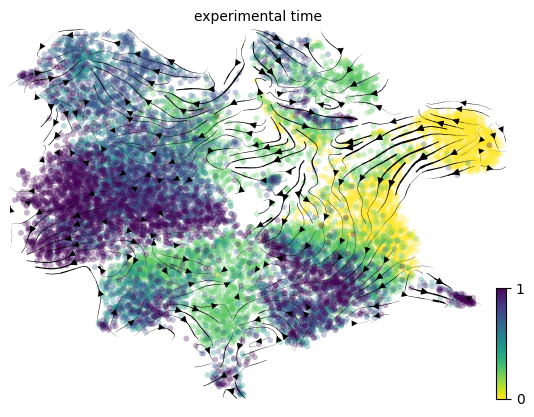

In [18]:
scv.pl.velocity_embedding_stream(adata_latent, vkey="T_fwd", basis="umap", color="experimental_time")

**Sample latent trajectory**

In [19]:
traj = model.sample_trajectory(teacher_forcing=True)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)

In [ ]:
X_pf = traj.view(traj.shape[0]*traj.shape[1], -1)
times = torch.arange(5).unsqueeze(0).expand(traj.shape[0],5).ravel()
times = pd.DataFrame(times)
times.columns = ["experimental_time"]

In [ ]:
adata_pf = sc.AnnData(X=X_pf.cpu().numpy(), 
                     obs=times)

In [ ]:
sc.tl.pca(adata_pf)
sc.pp.neighbors(adata_pf)
sc.tl.umap(adata_pf)

In [ ]:
sc.pl.umap(adata_pf, color="experimental_time")

In [ ]:
X_tot = torch.cat([X_pf, z_cells], dim=0)
annot_tot = pd.concat([times, annot], axis=0)
annot_tot["Dataset"] = ["generated" for _  in range(len(X_pf))]+["true" for _  in range(len(z_cells))]

In [ ]:
adata_tot = sc.AnnData(X=X_tot.cpu().numpy(), 
                     obs=annot_tot)

In [ ]:
sc.tl.pca(adata_tot)
sc.pp.neighbors(adata_tot)
sc.tl.umap(adata_tot)

In [ ]:
sc.pl.umap(adata_tot, color=["experimental_time", "Dataset"])